# Week 1: Percolation theory 

Welcome to CPP! This is the jupyter notebook for the tasks of the first week. In this notebook, we will: 
1) Initialise a system 
2) Identify the clusters in the system 
3) Analyse various properties such as average size, probability of percolating, etc. 

I have added descriptions, links and hints; this assignment has been made such that google, stackexchange, and python documentation should be more than enough to do this easily. While I cannot control what you do, I encourage you to not go to LLMs to do these tasks. They are easy enough and are instructive and will help you learn more python, which vibecoding will not.

I will also encourage you to comment your code if you get time; it will help when you look back at the code when you are making your report. 

Feel free to ask doubts in the group or in my DMs! 

## 1. Initialising the system

In the cell below, write a function which takes in two values: $n$, which is the length of the square grid we are making, and $p$ which is the probability that a square is filled (or black), and returns a 2D array which will be our grid.

Hint: np.random.rand

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
# initially, I thought of using classes
# but it wasn't really necessary
# class PercolationSystem:
#     def __init__(self, n, p):
#         # check if p and n are valid
#         self.grid_size = (n, n)
#         self.concentration = p
#         self.grid = np.random.rand(n, n) < p

def init_system(n, p):
    return np.random.rand(n,n) < p

## 2. Identifying and Labelling clusters: Hoshen Kopelman algorithm

From the previous section you now have a 2D numpy array which is a grid with "True" and "False" values. Your task now is to write a function that scans the grid and assigns a unique integer label to each connected cluster of occupied sites.

A cluster is defined as a group of occupied sites that are connected to each other through nearest neighbours (up, down, left, right). 

Define a function, which takes in the 2D array as input, and returns a new array labels of the same shape, where:

1) labels[i, j] = 0 if the site is empty
2) labels[i, j] = k if the site belongs to cluster k

Clusters that are connected (via nearest neighbours) must have the same label. This is the hardest part of the assignment. Not to worry, I have given a detailed outline of the algorithm below. Try to google, stackexchange and use python documentation before moving to some LLM; this is a good time to learn python, and vibe coding is not the same as learning. 

You can learn more about this algorithm in the following link: https://en.wikipedia.org/wiki/Hoshen%E2%80%93Kopelman_algorithm


In [8]:
class DisjointSet:
    def __init__(self, size):
        self.parent = np.arange(size, dtype=int)
        self.rank = np.zeros(size, dtype=int)

    def find(self, label):
        root = label

        # climb up the tree
        while self.parent[root] != root:
            root = self.parent[root]

        # path compression
        while self.parent[label] != label:
            parent_label = self.parent[label]
            self.parent[label] = root
            label = parent_label

        return root

    def union(self, label1, label2):
        # ignore unoccupied
        if label1 == 0 or label2 == 0:
            return

        root1 = self.find(label1)
        root2 = self.find(label2)

        # ignore if labels already have same root
        if root1 == root2:
            return

        # union by rank
        if self.rank[root1] < self.rank[root2]:
            self.parent[root1] = root2
        elif self.rank[root1] > self.rank[root2]:
            self.parent[root2] = root1
        else:
            # same rank case
            self.parent[root2] = root1
            self.rank[root1] += 1


def label_clusters(grid):
    n = grid.shape[0]
    largest_label = 0
    label = np.zeros((n, n), dtype=int)

    disjoint_set = DisjointSet(n * n + 1)

    for i in range(n):
        for j in range(n):
            # if grid's occupied, else do nothing
            if grid[i, j]:
                left = label[i, j - 1] if j != 0 else 0
                above = label[i - 1, j] if i != 0 else 0

                if left == 0 and above == 0:
                    largest_label += 1
                    label[i, j] = largest_label
                elif left == 0 and above != 0:
                    label[i, j] = disjoint_set.find(above)
                elif above == 0 and left != 0:
                    label[i, j] = disjoint_set.find(left)
                else:
                    # left and above are belong to the same cluster
                    disjoint_set.union(left, above)
                    label[i, j] = disjoint_set.find(above)

    # final pass to flatten the tree
    for i in range(n):
        for j in range(n):
            if label[i, j] != 0:
                label[i, j] = disjoint_set.find(label[i, j])

    return label

## 3. Check if the system percolated 

Check if the system has percolated or not by checking if there is a cluster label appearing on opposite edges of the system. No hints for this one! 

In [9]:
def percolates(label):
    top = label[0, :]
    bottom = label[-1, :]
    left = label[:, 0]
    right = label[:, -1]

    top_ids = set(top[top != 0])
    bottom_ids = set(bottom[bottom != 0])
    left_ids = set(left[left != 0])
    right_ids = set(right[right != 0])

    if top_ids & bottom_ids:
        return True
    if left_ids & right_ids:
        return True

    return False

## 4. Visualise your grid! 

Visualisation is very important; it is very useful while debugging, also gives physical insights. Hint: use matplotlib's matshow to plot your grid along with the label of the cluster. You can also colour code the labels too! Check out the various colourmaps matplotlib has to offer. 

False


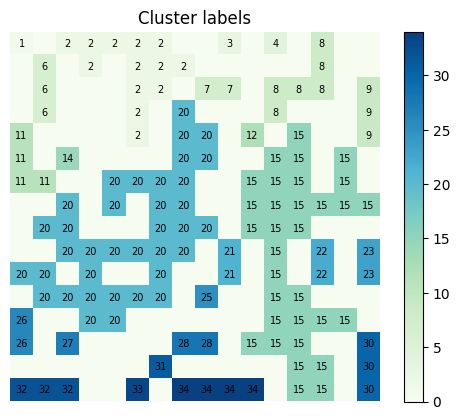

In [25]:
test_grid = init_system(16, 0.5)
test_labels = label_clusters(test_grid)

print(percolates(test_labels))

plt.imshow(test_labels, cmap="GnBu")
plt.colorbar()

for i in range(test_labels.shape[0]):
    for j in range(test_labels.shape[1]):
        if test_labels[i, j] != 0:
            plt.text(
                j, i, test_labels[i, j],
                ha="center", va="center",
                color="black", fontsize=7
            )

plt.title("Cluster labels")
plt.axis("off")
# plt.savefig("grid_example.png", dpi=300)
plt.show()

### Analysis time! 

That's all the prep needed! Now for squares of length 8,16 and 32, find the following as a function of $p$

1) Find the weighted average of the cluster size. If the system is percolating, do not count the percolating cluster. 
2) Find percolation strength (this is the size of the percolating system divided by the size of the system. If system does not percolate, this value is 0)
3) Find the percolation rate (find the probability that the system will percolate)

Initialise $N$ number of systems and average over them to get probability. Plot these three using matplotlib. Based on these plots, give comments regarding your observations. If you see a phase transition, can you estimate its critical probability? 
   
You can learn more about percolation and these terms from the following reference: 
1) https://www.mit.edu/~levitov/8.334/notes/percol_notes.pdf

The reference is advanced, so don't worry if you cannot understand it fully. 

In [11]:
class PercolationSystem:
    def __init__(self, N, L, p):
        """
        Initializes N configurations of size L x L,
        all with occupation probability p,
        labels the clusters, and
        filters the percolated cluster labels

        Parameters:
        N (int): Number of configurations
        L (int): Size of the grid
        p (float): Occupation Probability
        """
        self.N = N
        self.L = L
        
        self.grids = np.random.rand(N, L, L) < p
        self.labels = [label_clusters(grid) for grid in self.grids]
        self.percolated_labels = [self._get_percolated_labels(i) for i in range(N)]
        
        self.cluster_size = None
        self.percolation_strength = None
        self.percolation_probability = None

    def analyze_percolation(self):
        """
        Calculates
        1. cluster size
        2. percolation strength
        3. percolation probability
        """
        self.cluster_size = np.mean([self._cal_cluster_size(i) for i in range(self.N)])
        self.percolation_strength = np.mean([self._cal_percolation_strength(i) for i in range(self.N)])
        self._cal_percolation_probability()

    def _cal_cluster_size(self, i):
        """
        Returns the weighted average cluster size
        of the ith configuration
        """
        label = self.labels[i]
        values, freqs = np.unique(label, return_counts=True)
        freq_arr = np.vstack([values, freqs])
        
        # remove percolating cluster labels and 0s
        mask = (~np.isin(freq_arr[0], self.percolated_labels[i])) & (freq_arr[0] != 0)
        freq_arr = freq_arr[:, mask]

        if freq_arr.shape[1] == 0:
            return 0

        wt_avg = (freq_arr[1]**2).sum() / freq_arr[1].sum()
        return wt_avg

    def _cal_percolation_strength(self, i):
        """
        Returns the percolation strength
        of the ith configuration
        """
        total_size = float(self.L ** 2)
        label = self.labels[i]
        perc_labels = self.percolated_labels[i]

        if len(perc_labels) == 0:
            return 0.0

        sizes = []
        for perc_label in perc_labels:
            sizes.append(np.sum(perc_label == label))

        # considering only the largest percolating cluster
        largest = max(sizes)
            
        return largest / total_size

    def _cal_percolation_probability(self):
        """
        Calculates the percolation probability
        """
        num_percolating = sum(perc_label.size > 0 for perc_label in self.percolated_labels)
        self.percolation_probability = num_percolating / self.N

    def _get_percolated_labels(self, i):
        label = self.labels[i]
        edges = [
            label[0], label[-1],
            label[:,0], label[:,-1]
        ]
    
        edges = [edge[edge != 0] for edge in edges]
    
        top_bottom = np.intersect1d(edges[0], edges[1])
        left_right = np.intersect1d(edges[2], edges[3])
    
        percolating_labels = np.unique(np.union1d(top_bottom, left_right))
    
        return percolating_labels

In [17]:
N = 5000
# N = 50
length = [8, 16, 32]
p_values = np.linspace(0, 1, 200)

avg_cluster_sizes = {l: [] for l in length}
avg_percolation_strength = {l: [] for l in length}
percolation_probability = {l: [] for l in length}

for l in length:
    for p in tqdm(p_values, desc=f"Processing Length {l}"):
        system = PercolationSystem(N, l, p)
        system.analyze_percolation()
        avg_cluster_sizes[l].append(system.cluster_size)
        avg_percolation_strength[l].append(system.percolation_strength)
        percolation_probability[l].append(system.percolation_probability)

Processing Length 32: 100%|████████████████████████████████| 200/200 [10:27<00:00,  3.14s/it]


In [20]:
L_biggest = max(length)
p_c_true = 0.5927  # for 2D site percolation
p_c_peak = float(p_values[np.argmax(avg_cluster_sizes[L_biggest])])

def find_crossing(p_vals, y1, y2, target=0.6, min_prob=0.05):
    p_vals = np.asarray(p_vals)
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)
    diff = y1 - y2
    idx = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0]
    candidates = []
    for i in idx:
        # ignore initial noise
        local_max = np.max([y1[i], y2[i], y1[i + 1], y2[i + 1]])
        if local_max < min_prob:
            continue
        x0, x1 = p_vals[i], p_vals[i + 1]
        y0, y1v = diff[i], diff[i + 1]
        cross = x0 - y0 * (x1 - x0) / (y1v - y0)
        candidates.append(cross)
    if not candidates:
        return np.nan
    # choose the crossing near p_c_true, since others are noise
    candidates = np.asarray(candidates)
    return float(candidates[np.argmin(np.abs(candidates - target))])

pc_cross_8_16 = find_crossing(p_values, percolation_probability[8], percolation_probability[16], target=p_c_true)
pc_cross_16_32 = find_crossing(p_values, percolation_probability[16], percolation_probability[32], target=p_c_true)
p_c_cross = np.nanmean([pc_cross_8_16, pc_cross_16_32])

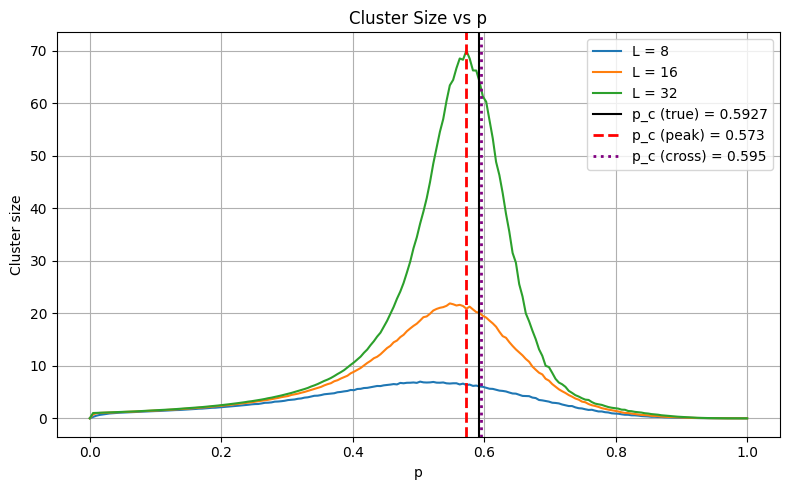

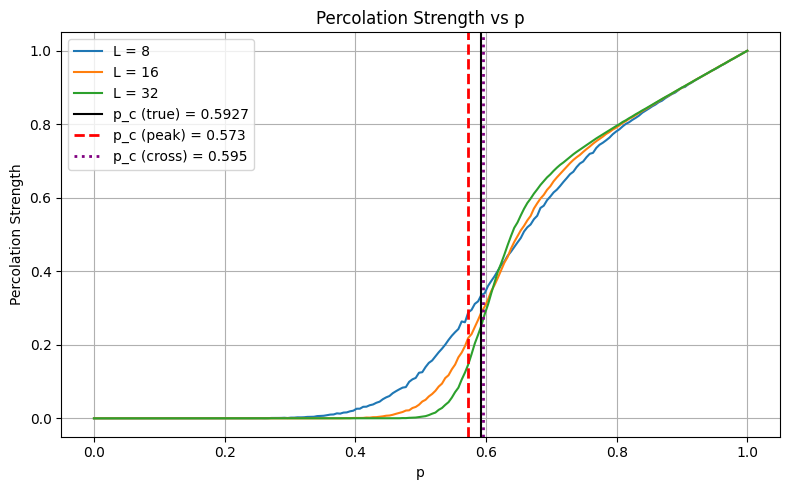

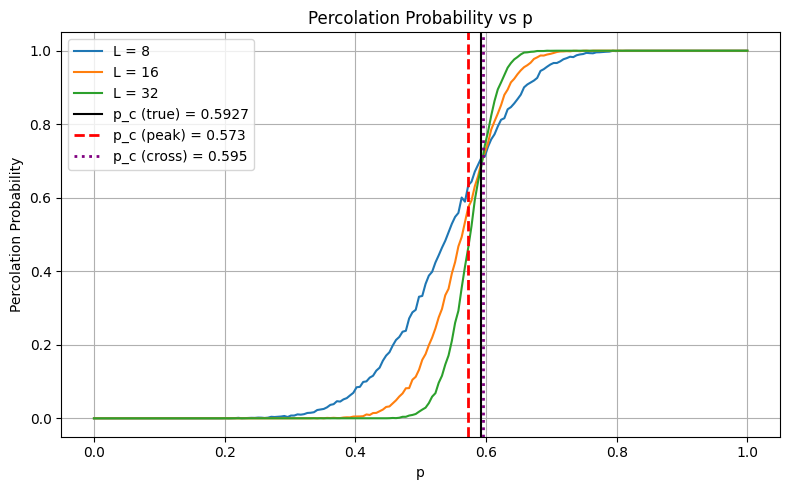

In [23]:
vlines = [
    (p_c_true, "black", "-", 1.5, f"p_c (true) = {p_c_true:.4f}"),
    (p_c_peak, "red", "--", 2, f"p_c (peak) = {p_c_peak:.3f}"),
    (p_c_cross, "purple", ":", 2, f"p_c (cross) = {p_c_cross:.3f}")
]

def add_vlines():
    for x, color, ls, lw, label in vlines:
        plt.axvline(x=x, color=color, linestyle=ls, linewidth=lw, label=label)

plots = [
    ("Cluster Size vs p", avg_cluster_sizes, "Cluster size", "cluster_size_vs_p.png"),
    ("Percolation Strength vs p", avg_percolation_strength, "Percolation Strength", "percolation_strength_vs_p.png"),
    ("Percolation Probability vs p", percolation_probability, "Percolation Probability", "percolation_probability_vs_p.png"),
]

for title, data_array, ylabel, filename in plots:
    plt.figure(figsize=(8, 5))

    for L in length:
        plt.plot(p_values, data_array[L], label=f"L = {L}")

    add_vlines()
    plt.xlabel("p")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(filename, dpi=300)
    plt.show()

## Bonus: Bethe lattice

Read about the Bethe lattice: https://en.wikipedia.org/wiki/Bethe_lattice 

Can you find its critical probability? It's a very neat answer and does not require code. 

## Bonus 2.0: Bond percolation 

Find what bond percolation is and try out the above tasks for 2D lattice but with bonds instead of filled/unfilled sites. This is trickier though, so try this if you have time. Is the critical probability same or different? 